<a href="https://colab.research.google.com/github/BarelHeby/Deep-Learning---Chest-X-Ray/blob/main/Deep_Learning_Chest_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning  - Final Project**

---



**Project Overview**

This project aims to apply advanced deep learning techniques learned during the semester to classify X-ray images. Utilizing the Chest X-ray dataset from Kaggle, we will train and evaluate models, demonstrating the practical application of the techniques acquired from the course.

Download Kaggle Xray Dataset

In [1]:
!pip install -q kaggle
from google.colab import files

# Create a Kaggle API token and save it to a file.
!echo '{"username":"barelheby","key":"978bdd6cd1cc991c69bbe920fe75a9cc"}' > kaggle.json

# Copy the Kaggle API token file to the correct location.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

# Change the permissions of the Kaggle API token file.
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle.
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded dataset.
!unzip -q chest-xray-pneumonia.zip

# Print the contents of the current working directory.
!ls


 99% 2.28G/2.29G [00:19<00:00, 70.0MB/s]
100% 2.29G/2.29G [00:19<00:00, 128MB/s] 
chest_xray  chest-xray-pneumonia.zip  kaggle.json  sample_data


Imports

In [2]:
import pandas as pd
from os.path import join
import tensorflow as tf
from keras import Sequential,models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import ResNet152
from keras.layers import BatchNormalization,Dropout,Dense,Flatten,UpSampling2D,Conv2D
from tensorflow.keras.optimizers import Adamax,Adam
import os
import shutil
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.manifold import TSNE
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import cv2
from tensorflow.keras.preprocessing import image as tfImage

Constants


In [3]:
TF_BATCH_SIZE = 32
TF_SEED = 123
IMG_HEIGHT = 256
IMG_WIDTH = 256
DIR_DATASET = "/content/chest_xray"

# Data Exploration
This section will be used to view the data in order to be able to understand it better.

NORMAL IMAGES

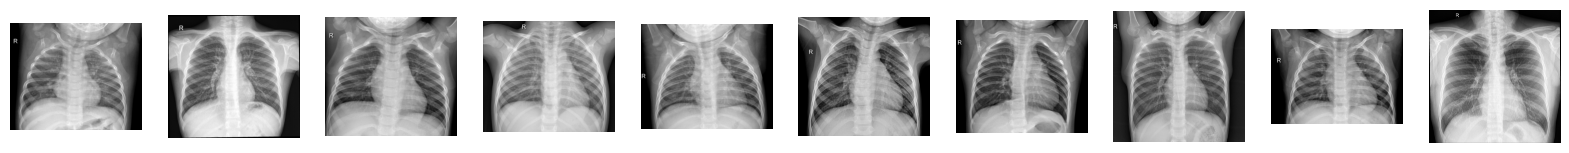

In [ ]:
normal_files_path = [os.path.join(DIR_DATASET,"train","NORMAL",f) for f in os.listdir(os.path.join(DIR_DATASET,"train","NORMAL"))][:10]
fig, axes = plt.subplots(1, 10,figsize=(20,20))
for index,img in enumerate(normal_files_path):
  image = cv2.imread(img)
  axes[index].imshow(image)
  axes[index].axis("off")

Abnormal Images

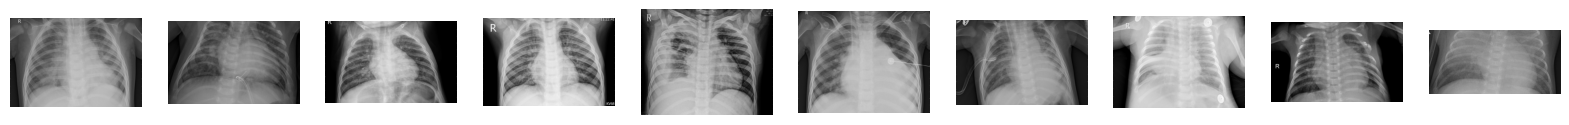

In [ ]:
abnormal_files_path = [os.path.join(DIR_DATASET,"train","PNEUMONIA",f) for f in os.listdir(os.path.join(DIR_DATASET,"train","PNEUMONIA"))][:10]
fig, axes = plt.subplots(1, 10,figsize=(20,20))
for index,img in enumerate(abnormal_files_path):
  image = cv2.imread(img)
  axes[index].imshow(image)
  axes[index].axis("off")


# Assigment 1 - Binary Classification

---



Data Loading

In [9]:
train_directory = join(DIR_DATASET,"train")
test_directory = join(DIR_DATASET,"test")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_directory,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [10]:
train_dataset.class_names

['NORMAL', 'PNEUMONIA']

**Model**

In order to get the max feture extruction for this task, We will use *Transfare Learning technique* from VGG16 as the base network for this mission.

In [11]:
base_network = VGG16(weights="imagenet",include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network.trainable = False
model_assigment_1  = Sequential(name="Assigment_1")
model_assigment_1.add(base_network)
model_assigment_1.add(Flatten())
model_assigment_1.add(Dense(512,activation="relu"))
model_assigment_1.add(Dropout(0.50))
model_assigment_1.add(Dense(128,activation="relu"))
model_assigment_1.add(Dropout(0.25))
model_assigment_1.add(Dense(60,activation="relu"))
model_assigment_1.add(Dense(1,activation="sigmoid"))
model_assigment_1.compile(optimizer=Adam(),loss='binary_crossentropy', metrics=['accuracy'])
model_assigment_1.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "Assigment_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_assigment_1.fit(train_dataset,
                        epochs= 20,
                        validation_data = validation_dataset,
                        callbacks = early_stopping)

Epoch 1/20
131/131 [==============================] - 60s 344ms/step - loss: 0.3631 - accuracy: 0.8653 - val_loss: 0.1134 - val_accuracy: 0.9626
Epoch 2/20
131/131 [==============================] - 39s 287ms/step - loss: 0.1764 - accuracy: 0.9276 - val_loss: 0.1127 - val_accuracy: 0.9626
Epoch 3/20
131/131 [==============================] - 38s 281ms/step - loss: 0.1337 - accuracy: 0.9487 - val_loss: 0.1315 - val_accuracy: 0.9473
Epoch 4/20
131/131 [==============================] - 38s 279ms/step - loss: 0.1183 - accuracy: 0.9538 - val_loss: 0.0943 - val_accuracy: 0.9693
Epoch 5/20
131/131 [==============================] - 38s 280ms/step - loss: 0.1161 - accuracy: 0.9530 - val_loss: 0.0882 - val_accuracy: 0.9684
Epoch 6/20
131/131 [==============================] - 41s 294ms/step - loss: 0.0968 - accuracy: 0.9643 - val_loss: 0.0881 - val_accuracy: 0.9684
Epoch 7/20
131/131 [==============================] - 37s 275ms/step - loss: 0.0960 - accuracy: 0.9612 - val_loss: 0.0907 - val_ac

Lets review our the training process.

We will divide our review for 2 sections: accuracy and loss.


**Accuracy**

We can see that in each epoch the accuracy will become higher than before.

Same for the training and validation data.
The main part that we should consider is that the accuracy of the train data will not be much more than the validation data.

If this was the case, we should be concered about overfitting.  

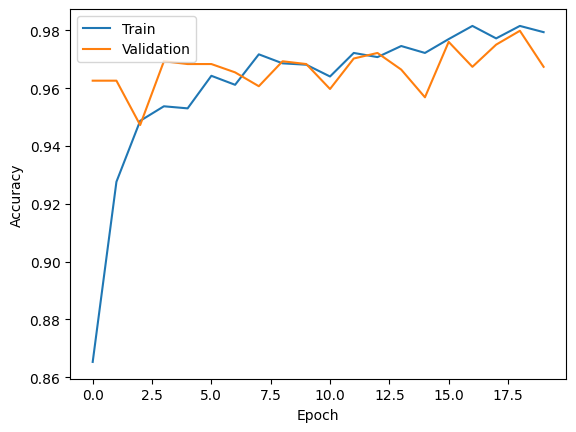

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Loss**

The loss values are getting smaller both training and validation data.

This what we should expect for the same resone as the accuracy.

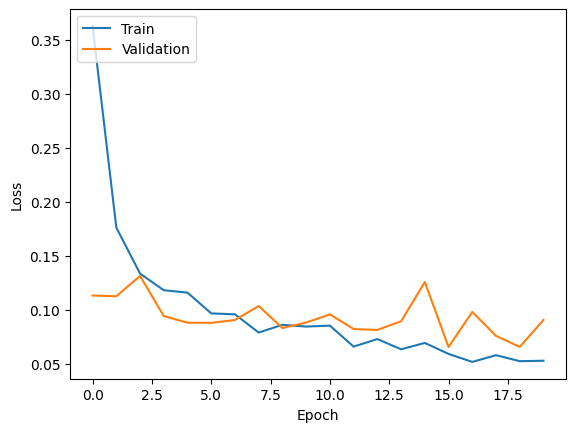

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

After training the model, lets check the performance on the test dataset

In [15]:
test_loss, test_accuracy = model_assigment_1.evaluate(test_dataset)
print("Test Set  Loss:", test_loss)
print("Test Set Accuracy:", test_accuracy)

20/20 [==============================] - 9s 397ms/step - loss: 0.6267 - accuracy: 0.8638
Test Set  Loss: 0.6266862750053406
Test Set Accuracy: 0.8637820482254028


In [16]:
model_assigment_1.save("model_assigment_1.keras")

# Assigment 1.2 - Categorial Classification


---



In [25]:
DIR_ASS_2 = join(DIR_DATASET,"assiment_2_dataset")
DIR_ASS_2_BACTERIA  = join(DIR_ASS_2,"BACTERIA")
DIR_ASS_2_VIRUS = join(DIR_ASS_2,"VIRUS")
DIR_ASS_2_NORMAL = join(DIR_ASS_2,"NORMAL")

try:
  shutil.rmtree(DIR_ASS_2)
except Exception as e:
  pass
try:
  os.mkdir(DIR_ASS_2)
  os.mkdir(DIR_ASS_2_BACTERIA)
  os.mkdir(DIR_ASS_2_VIRUS)
  os.mkdir(DIR_ASS_2_NORMAL)
except Exception as e:
  pass

Copy Images From Source To New Folder

Copy Sick

In [26]:
source_dir = join(DIR_DATASET,"train","PNEUMONIA")
for filename in os.listdir(source_dir):
  if "bacteria" in filename.lower():
    dest_dir  = DIR_ASS_2_BACTERIA
  elif "virus" in filename.lower():
    dest_dir = DIR_ASS_2_VIRUS
  else:
    pass
  shutil.copy(join(source_dir,filename),dest_dir)



Copy Normal

In [27]:
source_dir = join(DIR_DATASET,"train","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),DIR_ASS_2_NORMAL)

Data Loading

In [28]:
train_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "training",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)
validation_dataset_ass_2 = tf.keras.utils.image_dataset_from_directory(
    DIR_ASS_2,
    validation_split=0.2,
    subset = "validation",
    seed = TF_SEED,
    image_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = TF_BATCH_SIZE,
    label_mode = "categorical",
)

Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.


In [ ]:
train_dataset_ass_2.class_names

['BACTERIA', 'NORMAL', 'VIRUS']

**Model**

For this task we will use Transfare learning from ResNet152.

After few attemps, we figure out that this network as the base network provides the best performance for this task.

The network will pull out the fetures from the base network, and with 4 layers of Dense with Dropout between we get the best result without worried about overfitting.

In [29]:
base_network_ass_2 = ResNet152(include_top=False,input_shape = (IMG_HEIGHT,IMG_WIDTH,3),pooling="avg")
base_network_ass_2.trainable = False
model_assigment_2  = Sequential(name="Assigment_2")
model_assigment_2.add(base_network_ass_2)
model_assigment_2.add(Dense(1024,activation="relu"))
model_assigment_2.add(Dropout(0.3))
model_assigment_2.add(Dense(512,activation="relu"))
model_assigment_2.add(Dropout(0.2))
model_assigment_2.add(Dense(64,activation="relu"))
model_assigment_2.add(Dense(3,activation="softmax"))
model_assigment_2.compile(optimizer=Adam(),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_assigment_2.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "Assigment_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                      

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_ass_2 = model_assigment_2.fit(train_dataset_ass_2,
                        epochs= 50,
                        validation_data = validation_dataset_ass_2,
                        callbacks = early_stopping)

Epoch 1/50
131/131 [==============================] - 69s 415ms/step - loss: 0.6959 - categorical_accuracy: 0.7213 - val_loss: 0.5249 - val_categorical_accuracy: 0.7824
Epoch 2/50
131/131 [==============================] - 49s 365ms/step - loss: 0.5066 - categorical_accuracy: 0.7855 - val_loss: 0.5108 - val_categorical_accuracy: 0.7967
Epoch 3/50
131/131 [==============================] - 49s 362ms/step - loss: 0.4785 - categorical_accuracy: 0.7965 - val_loss: 0.4809 - val_categorical_accuracy: 0.8054
Epoch 4/50
131/131 [==============================] - 49s 361ms/step - loss: 0.4577 - categorical_accuracy: 0.8033 - val_loss: 0.4723 - val_categorical_accuracy: 0.8063
Epoch 5/50
131/131 [==============================] - 49s 361ms/step - loss: 0.4476 - categorical_accuracy: 0.8097 - val_loss: 0.4528 - val_categorical_accuracy: 0.8063
Epoch 6/50
131/131 [==============================] - 48s 358ms/step - loss: 0.4379 - categorical_accuracy: 0.8160 - val_loss: 0.4817 - val_categorical_acc

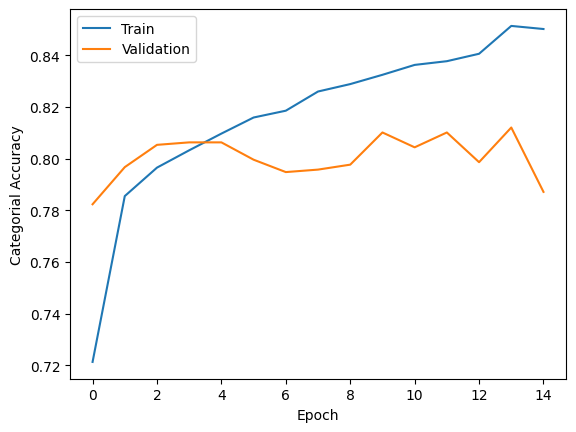

In [32]:
plt.plot(history_ass_2.history['categorical_accuracy'])
plt.plot(history_ass_2.history['val_categorical_accuracy'])
plt.ylabel('Categorial Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

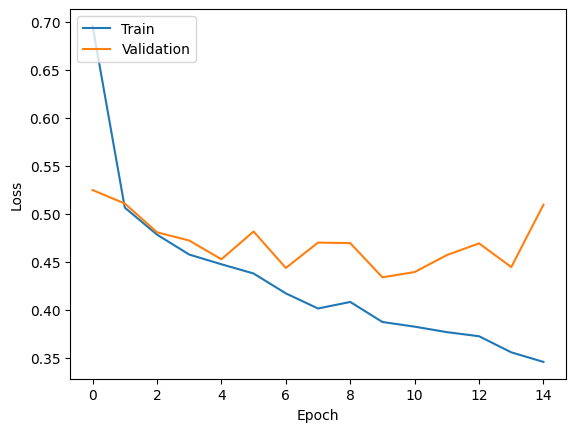

In [33]:
plt.plot(history_ass_2.history['loss'])
plt.plot(history_ass_2.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
validation_loss, validation_accuracy = model_assigment_2.evaluate(validation_dataset_ass_2)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

33/33 [==============================] - 11s 276ms/step - loss: 0.4340 - categorical_accuracy: 0.8102
Validation Loss: 0.4339636564254761
Validation Accuracy: 0.8101630210876465


In [35]:
model_assigment_2.save("model_assigment_2.keras")

# Assigment 2 - KNN Classification

---

In this task, we were asked to use the models in previous sections, and create a classification of the data using the KNN Algorithm

Train The KNN Classifier Function

In [36]:
def train_knn_by_model(model,train_data):
  X_train = []
  y_train = []
  for batch, label in train_data:
      X_train.append(model.predict(batch))
      y_train.append(label)
  X_train = np.concatenate(X_train)
  y_train = np.concatenate(y_train)
  knn = KNeighborsClassifier(n_neighbors=5)
  knn.fit(X_train, y_train)
  return knn



Function To Classify New Image

In [37]:
def classify(new_image_path,model,knn_model,class_names,assigment_number):
  new_image = Image.open(new_image_path)
  new_image = new_image.resize((IMG_WIDTH,IMG_HEIGHT))
  new_image_array = np.array(new_image)
  new_image_array = np.expand_dims(new_image_array,axis=0)
  new_image_array = np.expand_dims(new_image_array,axis=-1)
  new_image_array = np.repeat(new_image_array, 3, axis=-1)
  new_image_tensor = tf.convert_to_tensor(new_image_array,tf.float32)
  # Create the embedding vector for the image
  new_image_embedding = model.predict(new_image_tensor)
  print("New Image Embedding",new_image_embedding)
  # Use knn to predict
  y_pred_knn = knn_model.predict(new_image_embedding)
  if assigment_number==1:
    return class_names[y_pred_knn[0]]
  y_pred_knn = y_pred_knn[0]
  for i in range(len(y_pred_knn)):
    if int(y_pred_knn[i])==1:
      return class_names[i]

**Predict New Image - Assigment 1.a**



In [38]:
knn_model_ass_1 = train_knn_by_model(model_assigment_1,train_dataset)

1/1 [==============================] - 0s 25ms/step


In [39]:
ass_1_class_names = ["NORMAL","PNEUMONIA"]
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_1,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: PNEUMONIA, Got:", classify(img_2,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))
img_3 = "/content/chest_xray/test/NORMAL/IM-0043-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_1,knn_model_ass_1,ass_1_class_names,1))

1/1 [==============================] - 0s 26ms/step
New Image Embedding [[1.]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 19ms/step
New Image Embedding [[0.9999958]]
Expected: PNEUMONIA, Got: PNEUMONIA
1/1 [==============================] - 0s 19ms/step
New Image Embedding [[0.00867288]]
Expected: NORMAL, Got: NORMAL


**Predict New Image - Assigment 1.b**



In [40]:
knn_model_ass_2 = train_knn_by_model(model_assigment_2,train_dataset_ass_2)

1/1 [==============================] - 4s 4s/step


In [41]:
img_1 = "/content/chest_xray/test/PNEUMONIA/person173_bacteria_830.jpeg"
print("Expected: BACTERIA, Got:", classify(img_1,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_2 = "/content/chest_xray/test/PNEUMONIA/person17_virus_48.jpeg"
print("Expected: VIRUS, Got:", classify(img_2,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))
img_3 = "/content/chest_xray/test/NORMAL/IM-0011-0001.jpeg"
print("Expected: NORMAL, Got:", classify(img_3,model_assigment_2,knn_model_ass_2,train_dataset_ass_2.class_names,2))

1/1 [==============================] - 1s 751ms/step
New Image Embedding [[9.2458522e-01 7.6223188e-07 7.5414024e-02]]
Expected: BACTERIA, Got: BACTERIA
1/1 [==============================] - 0s 34ms/step
New Image Embedding [[0.40965638 0.00270093 0.5876426 ]]
Expected: VIRUS, Got: VIRUS
1/1 [==============================] - 0s 35ms/step
New Image Embedding [[0.01638009 0.96953636 0.01408344]]
Expected: NORMAL, Got: NORMAL


Create Scatter Plots

In [42]:
embeddings_1 = model_assigment_1.predict(train_dataset)


131/131 [==============================] - 35s 253ms/step


In [43]:

tsne_data_1 = TSNE(n_components=1,perplexity=15)
tsne_data_1 = tsne_data_1.fit_transform(embeddings_1)
df_1 = pd.DataFrame(tsne_data_1, columns=["x"])
X_1 = df_1["x"]

y_names_1 = [validation_dataset.class_names[0 if row <0.5 else 1] for row in tsne_data_1]
fig_1 = px.scatter(df_1, color=y_names_1, opacity=0.8)
fig_1.show()


In [44]:
embeddings_2 = model_assigment_2.predict(train_dataset_ass_2)

131/131 [==============================] - 44s 302ms/step


In [45]:

tsne_data_2 = TSNE(n_components=3,perplexity=15).fit_transform(embeddings_2)
df = pd.DataFrame(tsne_data_2, columns=["x", "y", "z"])
X = df["x"]
y = df["y"]
z = df["z"]

y_names = [validation_dataset_ass_2.class_names[np.argmax(row)] for row in tsne_data_2]
fig = px.scatter(x=X, y=y,  color=y_names, opacity=0.8)
fig.show()


# Assigment 3 - Anomaly Detection

---
In This task, we will read only **NORMAL** xray images, and train a model that will know to indicate when the data is abnormal using anomaly detection

Copy data, create new folder that will used as the dataset

In [ ]:
source_dir = join(DIR_DATASET,"train","NORMAL")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3","NORMAL"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3","NORMAL")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3 = join(DIR_DATASET,"train_directory_ass_3")

source_dir = join(DIR_DATASET,"train","PNEUMONIA")
try:
  shutil.rmtree(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
except:
  pass
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia"))
os.mkdir(join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA"))
dest_dir = join(DIR_DATASET,"train_directory_ass_3_pneumonia","PNEUMONIA")
for filename in os.listdir(source_dir):
  shutil.copy(join(source_dir,filename),dest_dir)
train_directory_ass_3_pneumonia = join(DIR_DATASET,"train_directory_ass_3_pneumonia")

**Model**

This model is used VGG16 as the base model in order to extract fetures from the images . after the feture extruction phase, we have several Convulutional layers with diffrent numbers of filters in order to preserve the original image shape and look. the model will indicate that the image is normal if there is not a lot of diffrence (Threshold will be define) between the original image and the processed image.

We will use mse as the loss function for determine the diffrance between the original image and the predicted one.


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False
autoencoder = Sequential()
autoencoder.add(base_model)

autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
# Output layer
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Data loading

In [ ]:
ass_3_train_datagen = ImageDataGenerator(rescale=1./255)
ass_3_train_generator = ass_3_train_datagen.flow_from_directory(
        '/content/chest_xray/train_directory_ass_3',
        target_size=(256, 256),
        batch_size=32,
        class_mode='input')

ass_3_sick_generator = ass_3_train_datagen.flow_from_directory(
        '/content/chest_xray/train_directory_ass_3_pneumonia',
        target_size=(256, 256),
        batch_size=32,
        class_mode='input')

Found 1341 images belonging to 1 classes.
Found 3875 images belonging to 1 classes.


Train the model using only normal xray images.

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
autoencoder.fit(
        ass_3_train_generator,
        epochs=30,
        callbacks = [early_stopping])

This function is responsible to get the data as DirectoryIterator and return the mse value between the original image and the predicted one

In [ ]:
def get_mse_values(data):
  mse_values = []
  for i in range(len(data)):
    original_images, _ = data.next()
    reconstructed_images = autoencoder.predict(original_images,verbose=0)
    original_images = original_images.reshape(original_images.shape[0], -1)
    reconstructed_images = reconstructed_images.reshape(reconstructed_images.shape[0], -1)
    mse = mean_squared_error(original_images, reconstructed_images)
    mse_values.append(mse)
  return mse_values

**Exploration**

after training the model, lets check the threashold that we suppose to set.
we can see that the max value of mse of normal images is 0.00619, and for abnormal images, the min value is about 0.12.

Therefore we will set threshold to be around 0.007.

Mean: 0.0056245727
Max: 0.006190969


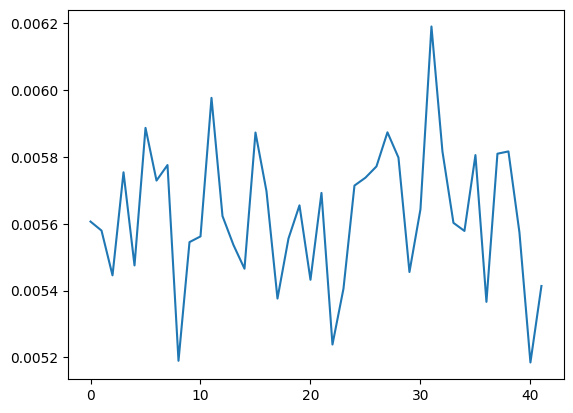

In [ ]:
mse_values_normal = get_mse_values(ass_3_train_generator)
print("Mean:",np.mean(mse_values_normal))
print("Max:",np.max(mse_values_normal))
plt.plot(mse_values_normal)
plt.show()

Mean: 0.016633961
Max: 0.026829662


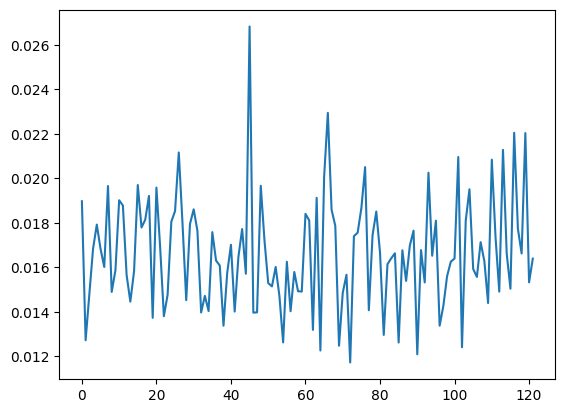

In [ ]:
mse_values_sick = get_mse_values(ass_3_sick_generator)
print("Mean:",np.mean(mse_values_sick))
print("Max:",np.max(mse_values_sick))
plt.plot(mse_values_sick)
plt.show()

Show the images before and after processing.
we can see that the normal images is look almost the same, but the abnormal images is very blury and not so close to the origin.

This indicate us that the model works as expected.

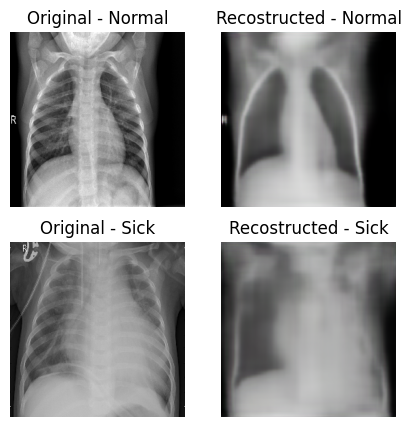

In [ ]:
first_image = np.array(ass_3_train_generator.next()[0][0])
first_image = first_image.reshape((1,) + first_image.shape)
fig, axes = plt.subplots(2, 2,figsize=(5,5))
axes[0][0].imshow(first_image[0])
axes[0][0].set_title("Original - Normal")
axes[0][0].axis("off")
axes[0][1].imshow((autoencoder.predict(first_image,verbose=0)*255).astype('uint8')[0])
axes[0][1].set_title("Recostructed - Normal")
axes[0][1].axis("off")

first_image_sick = np.array(ass_3_sick_generator.next()[0][0])
first_image_sick = first_image_sick.reshape((1,) + first_image_sick.shape)
axes[1][0].imshow(first_image_sick[0])
axes[1][0].set_title("Original - Sick")
axes[1][0].axis("off")
axes[1][1].imshow((autoencoder.predict(first_image_sick,verbose=0)*255).astype('uint8')[0])
axes[1][1].set_title("Recostructed - Sick")
axes[1][1].axis("off")
plt.show()

In [ ]:
autoencoder.save("model_assigment_3.keras")

# Assigment 4 - Explainability

---



Using heatmaps we can visualize which regions in the X-ray image are most important for the model's predictions. In the result picture of the heatmap the highlights parts are lung areas where pneumonia-related abnormalities are expected (such as consolidation or ground-glass opacity), it confirms that the model is making decisions based on relevant features. Conversely, if the heatmap highlights irrelevant areas (such as the image borders or labels), it may suggest that the model is relying on noise or artifacts, indicating a potential issue in the training data or preprocessing steps.

This technique helps not only in validating the model but also in understanding and improving the data preprocessing and training pipeline by ensuring that the model focuses on medically relevant features of the chest X-rays.

In [18]:
def load_preprocess_image(path, size):
    img = tfImage.load_img(path, target_size=size)
    img = tfImage.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    return img


In [19]:
def generate_occlusion_heatmap(model, img, occlusion_size=50, occlusion_pixel=0.5):
    original_img = img.copy()
    height, width, _ = original_img.shape[1:]
    heatmap = np.zeros((height, width))

    for y in range(0, height, occlusion_size):
        for x in range(0, width, occlusion_size):
            occluded_img = original_img.copy()
            occluded_img[0, y:y+occlusion_size, x:x+occlusion_size, :] = occlusion_pixel
            prediction = model.predict(occluded_img)

            # Update heatmap
            prediction_change = prediction[0][0]
            heatmap[y:y+occlusion_size, x:x+occlusion_size] = prediction_change

    return heatmap

In [22]:
def plot_heatmap(heatmap, img_path, alpha=0.6):
    img = tfImage.load_img(img_path)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)
    plt.colorbar()
    plt.show()

1/1 [==============================] - 0s 17ms/step


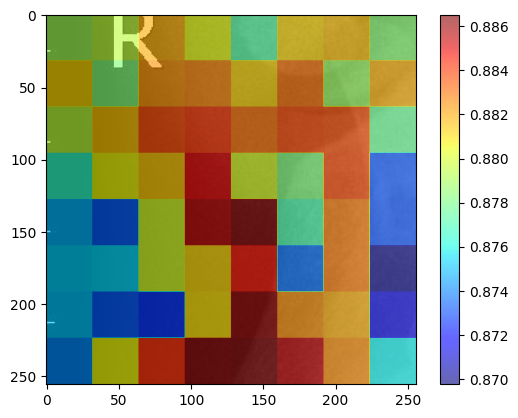

In [24]:
img_path = '/content/chest_xray/test/PNEUMONIA/person1640_virus_2839.jpeg'
img = load_preprocess_image(img_path, (256, 256))
heatmap = generate_occlusion_heatmap(model_assigment_1, img, occlusion_size=32)
plot_heatmap(heatmap, img_path)